In [1]:
from mylib.statistic_test import *

code_id = "0881 - Maze 1m Results"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)
pass

d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0881 - Maze 1m Results is already existed!


# PVC

In [3]:
def _pvc(ratemap1, ratemap2):
    pvc = np.zeros(111)
    for i in range(111):
        b = CP_DSPs[4][0][i]-1
        pvc[i] = np.corrcoef(ratemap1[:, b], ratemap2[:, b])[0, 1]
        
    idx = np.where(np.isnan(pvc) == False)[0]
    pvc[idx] = np.convolve(pvc[idx], np.ones(5)/5, mode='same')
        
    return pvc

def calc_pvc(trace):
    if 'node 15' in trace.keys():
        pvc = np.zeros((13, 111))
        routes = np.array([1, 2, 3, 7, 0, 4, 5, 6, 0, 8, 9, 10, 0])
        
        for i in range(1, 6):
            pvc[i-1, :] = _pvc(trace['node 0']['old_map_clear'], trace[f'node {i}']['old_map_clear'])

        for i in range(7, 11):
            pvc[i-2, :] = _pvc(trace['node 6']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
        
        for i in range(12, 16):
            pvc[i-3, :] = _pvc(trace['node 11']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
            
    else:
        pvc = np.zeros((9, 111))
        routes = np.array([1, 2, 3, 7, 0, 4, 5, 6, 0])
        
        for i in range(1, 6):
            pvc[i-1, :] = _pvc(trace['node 0']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
        
        for i in range(7, 11):
            pvc[i-2, :] = _pvc(trace['node 6']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
            
    return pvc, routes

if exists(join(figdata, f"{code_id} [PVC].pkl")) == False:
    PVCData = {
        "MiceID": [],
        "Session": [],
        "Bin": [],
        "PVC": [],
        "Route": []
    }
    
    for mouse in [10266]:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        print(f"{mouse}:")
        for s, idx in tqdm(enumerate(file_idx)):
            
            with open(f2['Trace File'][idx], 'rb') as f:
                trace = pickle.load(f)
            pvc, routes = calc_pvc(trace)
            bins = np.tile(np.arange(1, 112), (pvc.shape[0], 1))
            routes = np.tile(routes[:, np.newaxis], (1, pvc.shape[1]))
            mices = np.full(pvc.size, mouse)
            sessions = np.full(pvc.size, s)
            
            PVCData['MiceID'].append(mices.flatten())
            PVCData['Session'].append(sessions.flatten())
            PVCData['PVC'].append(pvc.flatten())
            PVCData['Route'].append(routes.flatten())
            PVCData['Bin'].append(bins.flatten())
            
    for key in PVCData.keys():
        PVCData[key] = np.concatenate(PVCData[key])
        
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'wb') as f:
        pickle.dump(PVCData, f)
        
    PVCD = pd.DataFrame(PVCData)
    PVCD.to_excel(join(figdata, f"{code_id} [PVC].xlsx"), index=False)
    print(len(PVCD))
else:
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'rb') as f:
        PVCData = pickle.load(f)

subdata_0 = SubDict(PVCData, PVCData.keys(), np.where(PVCData['Route'] == 0)[0])
save_loc = join(loc, "PVC")
mkdir(save_loc)
for rt in range(1, 11):    
    subdata = SubDict(PVCData, PVCData.keys(), np.where(np.isin(PVCData['Route'], [rt]))[0])
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x='Bin', 
        y='PVC', 
        hue='Session',
        data=subdata,
        linewidth=0.5,
        palette="rainbow",
        err_kws={'edgecolor': None},
        legend=False,
        ax=ax
    )
    sns.lineplot(
        x='Bin', 
        y='PVC', 
        hue='Route',
        data=subdata_0,
        linewidth=0.5,
        palette=[DSPPalette[0]],
        err_kws={'edgecolor': None},
        legend=False,
        ax=ax
    )
    ax.set_xlim(0, 112.5)
    ax.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
    ax.set_ylim(-0.1, 0.9)
    ax.set_yticks(np.linspace(-0.1, 0.9, 6))
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.set
    ax.set_title(f"Route {rt+1}")
    plt.savefig(join(save_loc, f"R{rt+1}.png"), dpi=600)
    plt.savefig(join(save_loc, f"R{rt+1}.svg"), dpi=600)
    plt.close()


10266:


11it [00:24,  2.19s/it]


13209
        D:\Data\FinalResults\Dsp\0881 - Maze 1m Results\PVC is made up successfully!


# Lapwise Correlation

In [ ]:
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

def get_lapwise_ratemap(trace: dict, is_cutted: bool = True):    
    maze_type = trace['maze_type']
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx, maze_type)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes)
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T

    X = np.transpose(smoothed_map, (2, 1, 0))
    return X, routes

file_idx = np.where(f2['MiceID'] == 10266)[0]
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(4*6, 4*2))
for s, idx in enumerate(file_idx):
    with open(f2['Trace File'][idx], 'rb') as f:
        trace = pickle.load(f)
    
    print(f"File {s+1}")
    lap_ratemap, rts = get_lapwise_ratemap(trace, is_cutted=True)
    corr = np.zeros((lap_ratemap.shape[0], lap_ratemap.shape[0]))
    for i in tqdm(range(lap_ratemap.shape[0])):
        for j in range(i, lap_ratemap.shape[0]):
            intersected_bins = np.intersect1d(
                CP_DSPs[4][rts[i]], CP_DSPs[4][rts[j]]
            )
            corr[i, j] = np.corrcoef(np.reshape(lap_ratemap[:, intersected_bins-1, :], (lap_ratemap.shape[0], -1)))[0, 1]
    ax: Axes = axes[s//6, s%6]
    ax.imshow(corr, vmin=0, vmax=1, cmap='jet')

File 1


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 114/114 [03:40<00:00,  1.93s/it]


File 2


100%|██████████| 121/121 [04:19<00:00,  2.15s/it]


File 3


100%|██████████| 114/114 [03:41<00:00,  1.95s/it]


File 4


 33%|███▎      | 41/123 [02:49<02:13,  1.63s/it]

# Decoding

In [2]:
save_decode_loc = join(loc, "GNB Decoding")
mkdir(save_decode_loc)

def combine_groups(
    trace, profiles: list[tuple[int, int]], effect_route: int
):
    res = {
        "Effect on Route": [],
        "Bin": [],
        "Loss": [],
        "Type": []
    }
    maze_type = trace['maze_type']
    assert maze_type == 4
    D = GetDMatrices(maze_type, nx=48)
    
    types = ["R1_2_Rt", "Rp_2_Rt", "Rp_2_R1", "R1_2_Rp", "Rt_2_R1", "Rt_2_Rp"]
    assert len(profiles) == len(types)
    for t, profile in enumerate(profiles):
        nb_model = NaiveBayesDecoder(maze_type=4, res=48, smooth_matrix=trace['Ms'])
        nb_model.fit(
            trace[f'node {profile[0]}']['Spikes'],
            trace[f'node {profile[0]}']['spike_nodes'].astype(np.int64)
        )
        y_test = trace[f'node {profile[1]}']['spike_nodes'].astype(np.int64)
        y_pred = nb_model.predict(trace[f'node {profile[1]}']['Spikes'], y_test)
        
        loss = D[(y_test-1, y_pred-1)]
        
        res['Effect on Route'].append(np.repeat(effect_route, y_test.shape[0]))
        res['Bin'].append(y_test)
        res['Loss'].append(loss)
        res['Type'].append(np.repeat(types[t], y_test.shape[0]))
        
    for key in res.keys():
        res[key] = np.concatenate(res[key])
        
    return res

def GNB_decoding(trace: dict):
    res = {
        "Effect on Route": [],
        "Bin": [],
        "Loss": [],
        "Type": []
    }
    # 0 1 2 3 4 5
    # 6 7 8 9 10
    # 11 12 13 14 15
    
    assert 'node 15' in trace.keys(), f"Node 15 not found in trace keys."
    
    print("  Test R5")
    res_rt = combine_groups(
        trace,
        profiles=[(6, 7), (12, 7), (12, 6), (6, 12), (7, 6), (7, 12)],
        effect_route=5
    )
    
    for key in res.keys():
        res[key].append(res_rt[key])    

    print("  \n\nTest R2")
    res_rt = combine_groups(
        trace,
        profiles=[(0, 1), (13, 1), (13, 0), (0, 13), (1, 0), (1, 13)],
        effect_route=2
    )
    
    for key in res.keys():
        res[key].append(res_rt[key])
    
    print("  \n\nTest R3")
    res_rt = combine_groups(
        trace,
        profiles=[(0, 2), (14, 2), (14, 0), (0, 14), (2, 0), (2, 14)],
        effect_route=3
    )
    
    for key in res.keys():
        res[key].append(res_rt[key])
    
    for key in res.keys():
        res[key] = np.concatenate(res[key])
        
    with open(join(save_decode_loc, f"{trace['date']}.pkl"), "wb") as f:
        pickle.dump(res, f)
        
    return res

for mouse in [10266]:
    file_idx = np.where((f2['MiceID'] == mouse)&(f2['date'] >= 20251221))[0]
    
    print(f"{mouse}:")
    for s, idx in tqdm(enumerate(file_idx)):
        print(f"Date {f2['date'][idx]}-----------------------")
        with open(f2['Trace File'][idx], 'rb') as f:
            trace = pickle.load(f)
        res = GNB_decoding(trace)
        print("Done. \n\n")

        D:\Data\FinalResults\Dsp\0881 - Maze 1m Results\GNB Decoding is already existed!
10266:


0it [00:00, ?it/s]

Date 20251221-----------------------
  Test R5
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.09100031852722168 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3478/3478 [01:39<00:00, 34.91it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08042287826538086 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3478/3478 [01:39<00:00, 35.04it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07400155067443848 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3680/3680 [01:43<00:00, 35.66it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07699346542358398 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3659/3659 [01:41<00:00, 36.13it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07101631164550781 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3680/3680 [01:41<00:00, 36.20it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06999707221984863 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3659/3659 [01:41<00:00, 36.15it/s]


  

Test R2
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07615828514099121 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2873/2873 [01:19<00:00, 36.14it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07215762138366699 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2873/2873 [01:19<00:00, 36.02it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06699728965759277 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3561/3561 [01:38<00:00, 36.05it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07426047325134277 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3313/3313 [01:31<00:00, 36.08it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06299877166748047 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3561/3561 [01:38<00:00, 36.18it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06000518798828125 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3313/3313 [01:31<00:00, 36.38it/s]


  

Test R3
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07400012016296387 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1816/1816 [00:50<00:00, 35.93it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07899975776672363 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1816/1816 [00:50<00:00, 36.08it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07599949836730957 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3561/3561 [01:38<00:00, 36.14it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06999969482421875 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3738/3738 [01:44<00:00, 35.94it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0429995059967041 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3561/3561 [01:38<00:00, 36.32it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04400038719177246 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3738/3738 [01:43<00:00, 36.17it/s]
1it [27:42, 1662.26s/it]

Done. 


Date 20251225-----------------------
  Test R5
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.09299969673156738 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3776/3776 [01:55<00:00, 32.74it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06692957878112793 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3776/3776 [01:52<00:00, 33.61it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08099365234375 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3935/3935 [02:02<00:00, 32.22it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.09020519256591797 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3534/3534 [01:49<00:00, 32.26it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08300328254699707 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3935/3935 [02:01<00:00, 32.45it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08599972724914551 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3534/3534 [01:49<00:00, 32.22it/s]


  

Test R2
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.09099626541137695 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3365/3365 [01:44<00:00, 32.05it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08299899101257324 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3365/3365 [01:44<00:00, 32.29it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08100008964538574 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4033/4033 [02:05<00:00, 32.25it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08999776840209961 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3422/3422 [01:46<00:00, 32.17it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07499980926513672 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4033/4033 [02:05<00:00, 32.19it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08108353614807129 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3422/3422 [01:46<00:00, 32.20it/s]


  

Test R3
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.09199976921081543 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2237/2237 [01:10<00:00, 31.94it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.059166908264160156 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2237/2237 [01:09<00:00, 32.15it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.05499410629272461 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4033/4033 [02:04<00:00, 32.39it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08899927139282227 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2160/2160 [01:07<00:00, 32.13it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0579981803894043 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4033/4033 [02:04<00:00, 32.35it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0559999942779541 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2160/2160 [01:07<00:00, 32.21it/s]
2it [59:21, 1801.51s/it]

Done. 


Date 20251227-----------------------
  Test R5
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08700060844421387 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3251/3251 [01:35<00:00, 34.15it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07200002670288086 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3251/3251 [01:36<00:00, 33.82it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07300329208374023 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3562/3562 [01:45<00:00, 33.75it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07700109481811523 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3269/3269 [01:35<00:00, 34.09it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07048559188842773 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3562/3562 [01:44<00:00, 33.95it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07299661636352539 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3269/3269 [01:36<00:00, 33.94it/s]


  

Test R2
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07699990272521973 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3011/3011 [01:28<00:00, 33.89it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07000136375427246 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3011/3011 [01:28<00:00, 34.03it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06800413131713867 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3502/3502 [01:42<00:00, 34.00it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07600021362304688 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3118/3118 [01:32<00:00, 33.64it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06999683380126953 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3502/3502 [01:43<00:00, 33.87it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06600475311279297 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3118/3118 [01:31<00:00, 33.95it/s]


  

Test R3
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07799959182739258 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1891/1891 [00:55<00:00, 33.84it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04599618911743164 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1891/1891 [00:55<00:00, 33.88it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.042999267578125 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3502/3502 [01:42<00:00, 34.18it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0749964714050293 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1742/1742 [00:50<00:00, 34.27it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0449986457824707 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3502/3502 [01:33<00:00, 37.48it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04399895668029785 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1742/1742 [00:46<00:00, 37.40it/s]
3it [1:25:39, 1699.40s/it]

Done. 


Date 20251229-----------------------
  Test R5
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07200264930725098 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3204/3204 [01:27<00:00, 36.53it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06299781799316406 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3204/3204 [01:27<00:00, 36.72it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06399869918823242 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3459/3459 [01:34<00:00, 36.69it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06900548934936523 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3067/3067 [01:23<00:00, 36.53it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06699848175048828 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3459/3459 [01:34<00:00, 36.44it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06599712371826172 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3067/3067 [01:23<00:00, 36.63it/s]


  

Test R2
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07199978828430176 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2773/2773 [01:15<00:00, 36.58it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06799173355102539 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2773/2773 [01:15<00:00, 36.61it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06908440589904785 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3614/3614 [01:38<00:00, 36.68it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07299304008483887 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3331/3331 [01:31<00:00, 36.59it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06299495697021484 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3614/3614 [01:38<00:00, 36.69it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.05800008773803711 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3331/3331 [01:30<00:00, 36.73it/s]


  

Test R3
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07373833656311035 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1724/1724 [00:47<00:00, 36.57it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04099297523498535 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1724/1724 [00:46<00:00, 36.80it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04099893569946289 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3614/3614 [01:37<00:00, 36.94it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07199358940124512 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1603/1603 [00:43<00:00, 36.52it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0429995059967041 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3614/3614 [01:38<00:00, 36.86it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.042014122009277344 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1603/1603 [00:43<00:00, 36.83it/s]
4it [1:49:48, 1600.65s/it]

Done. 


Date 20260101-----------------------
  Test R5
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07300281524658203 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3345/3345 [01:33<00:00, 35.86it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06599760055541992 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3345/3345 [01:33<00:00, 35.76it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06699132919311523 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3367/3367 [01:34<00:00, 35.78it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07199668884277344 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3124/3124 [01:27<00:00, 35.86it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06999850273132324 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3367/3367 [01:34<00:00, 35.74it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07100105285644531 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3124/3124 [01:27<00:00, 35.73it/s]


  

Test R2
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08048868179321289 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3004/3004 [01:24<00:00, 35.62it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.0709996223449707 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3004/3004 [01:24<00:00, 35.72it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07299280166625977 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4016/4016 [01:52<00:00, 35.57it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08086061477661133 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3404/3404 [01:35<00:00, 35.55it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06400012969970703 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4016/4016 [01:52<00:00, 35.81it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06600069999694824 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 3404/3404 [01:34<00:00, 35.83it/s]


  

Test R3
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08200597763061523 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1523/1523 [00:42<00:00, 35.67it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04799962043762207 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 1523/1523 [00:42<00:00, 35.91it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04900479316711426 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4016/4016 [01:51<00:00, 35.86it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08001494407653809 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2096/2096 [00:59<00:00, 35.51it/s]
d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04100489616394043 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 4016/4016 [01:51<00:00, 35.90it/s]


    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.04223012924194336 s


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


d:\Softwares\Anaconda2025\envs\maze\Lib\site-packages\mylib\decoder\NaiveBayesianDecoder.py:278: RuntimeWarning: divide by zero encountered in log
  P[:,t] = np.nansum(np.log(p), axis = 0) + np.log(pext_A)
100%|██████████| 2096/2096 [00:58<00:00, 35.95it/s]
5it [2:15:57, 1631.60s/it]

Done. 




<Axes: xlabel='X', ylabel='Loss'>

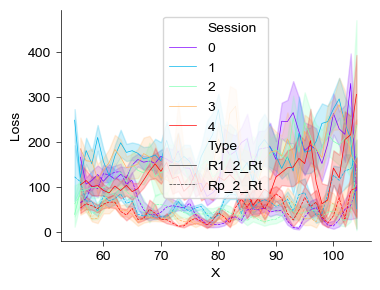

In [22]:
if exists(join(figdata, f"{code_id} [GNB Decoding].pkl")) == False:
    resort_res = {
        "Effect on Route": [],
        "Bin": [],
        "Loss": [],
        "Type": [],
        "Session": [],
    }
    
    for mouse in [10266]:
        file_idx = np.where((f2['MiceID'] == mouse)&(f2['date'] >= 20251221))[0]
        
        print(f"{mouse}:")
        for s, idx in tqdm(enumerate(file_idx)):
            with open(join(save_decode_loc, f"{f2['date'][idx]}.pkl"), "rb") as f:
                res = pickle.load(f)
            
                
            for key in resort_res.keys():
                if key == "Session":
                    resort_res[key].append(np.repeat(s, res['Bin'].shape[0]))
                else:
                    resort_res[key].append(res[key])
                
    for key in resort_res.keys():
        resort_res[key] = np.concatenate(resort_res[key])
        
    with open(join(figdata, f"{code_id} [GNB Decoding].pkl"), 'wb') as f:
        pickle.dump(resort_res, f)
        
    RResD = pd.DataFrame(resort_res)
    RResD.to_excel(join(figdata, f"{code_id} [GNB Decoding].xlsx"), index=False)
    print(len(RResD))
else:
    with open(join(figdata, f"{code_id} [GNB Decoding].pkl"), 'rb') as f:
        resort_res = pickle.load(f)

D = GetDMatrices(4, 48)
resort_res['X'] = D[resort_res['Bin']-1, 0] // 5
subdata = SubDict(resort_res, resort_res.keys(), 
                  np.where((resort_res['Effect on Route'] == 3)&(np.isin(resort_res['Type'], ["R1_2_Rt", "Rp_2_Rt"])))[0])

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='X',
    y='Loss',
    hue='Session',
    style='Type',
    palette="rainbow",
    data=subdata,
    linewidth=0.5
)
